In [ ]:
%pip install tqdm rich concurrent.futures --quiet

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
from rich import print

In [ ]:
size = (224, 224)
classes = ['Autistic', 'Non_Autistic']

In [40]:
def ld_img(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    img = cv2.cvtColor(cv2.resize(img, size), cv2.COLOR_BGR2RGB)
    
    folder_name = os.path.basename(os.path.dirname(path))
    label = classes.index(folder_name) if folder_name in classes else -1
    
    return img / 255.0, label

def ld(folder_path, max_workers=8):
    paths = glob.glob(os.path.join(folder_path, '**', '*.[jp][pn][g]'), recursive=True)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(ld_img, paths), total=len(paths), desc="Read"))
    
    images, labels = zip(*results) if results else ([], [])
    print(f'Loaded {len(images)} images from {folder_path}')
    return np.array(images), np.array(labels)

In [41]:
X_train, y_train = ld('datasets/AutismDataset/train')
X_val, y_val = ld('datasets/AutismDataset/valid')
X_test, y_test = ld('datasets/AutismDataset/test')

Read: 100%|██████████| 2540/2540 [00:01<00:00, 1788.31it/s]


Loaded 2540 images from datasets/AutismDataset/train

Read: 100%|██████████| 100/100 [00:00<00:00, 1759.39it/s]


Loaded 100 images from datasets/AutismDataset/valid

Read: 100%|██████████| 300/300 [00:00<00:00, 1538.70it/s]


Loaded 300 images from datasets/AutismDataset/test

In [42]:
print(f'Latih: {X_train.shape}, Validasi: {X_val.shape}, Test: {X_test.shape}')

Latih: (2540, 128, 128, 3), Validasi: (100, 128, 128, 3), Test: (300, 128, 128, 3)

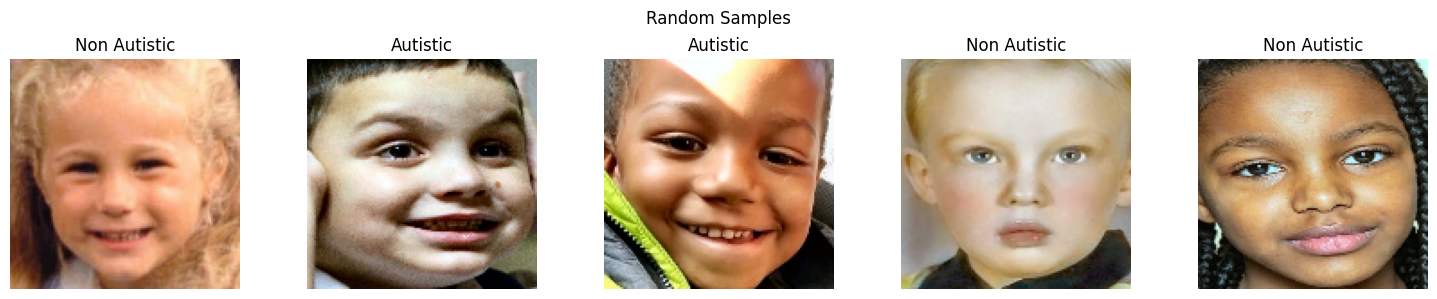

In [46]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(f"{'Autistic' if y_train[idx] == 0 else 'Non Autistic'}")
    ax.axis('off')
plt.suptitle('Random Samples')
plt.tight_layout()
plt.show()

In [47]:
print(X_train.shape)

(2540, 128, 128, 3)

In [52]:
model = keras.Sequential([
    layers.Input(shape=(size[0], size[1], 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │        57,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.6413 - loss: 0.6347 - val_accuracy: 0.6400 - val_loss: 0.5995


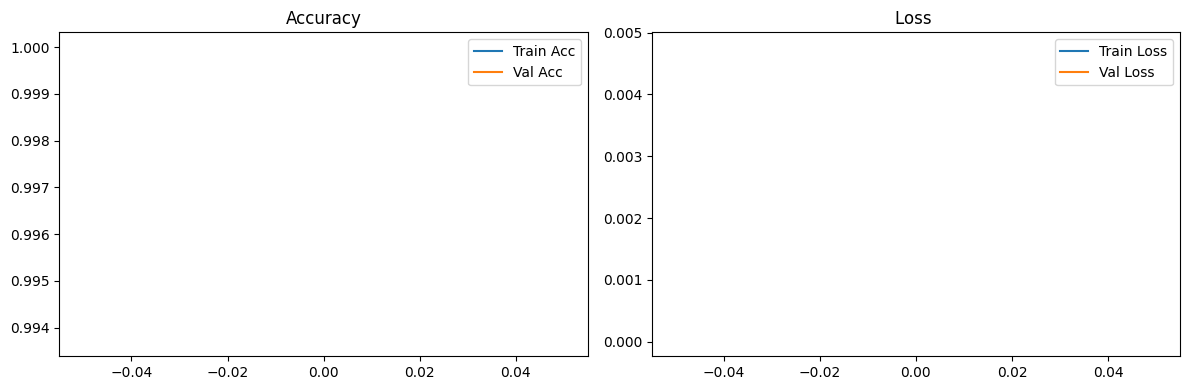

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='Train Acc')
ax1.plot(history.history['val_accuracy'], label='Val Acc')
ax1.set_title('Accuracy')
ax1.legend()
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Loss ')
ax2.legend()
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


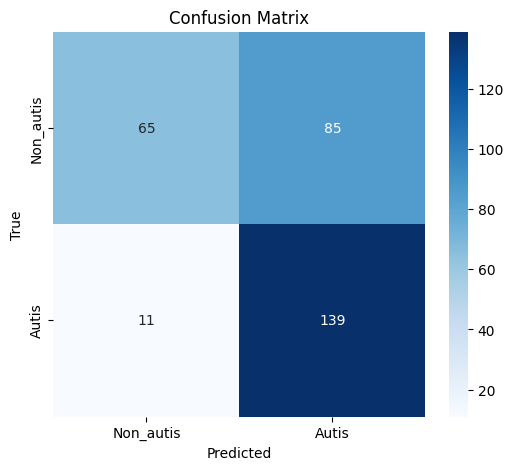

In [55]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non_autis', 'Autis'], yticklabels=['Non_autis', 'Autis'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [56]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Non_autis', 'Autis']))

Classification Report:

precision    recall  f1-score   support

   Non_autis       0.86      0.43      0.58       150
       Autis       0.62      0.93      0.74       150

    accuracy                           0.68       300
   macro avg       0.74      0.68      0.66       300
weighted avg       0.74      0.68      0.66       300

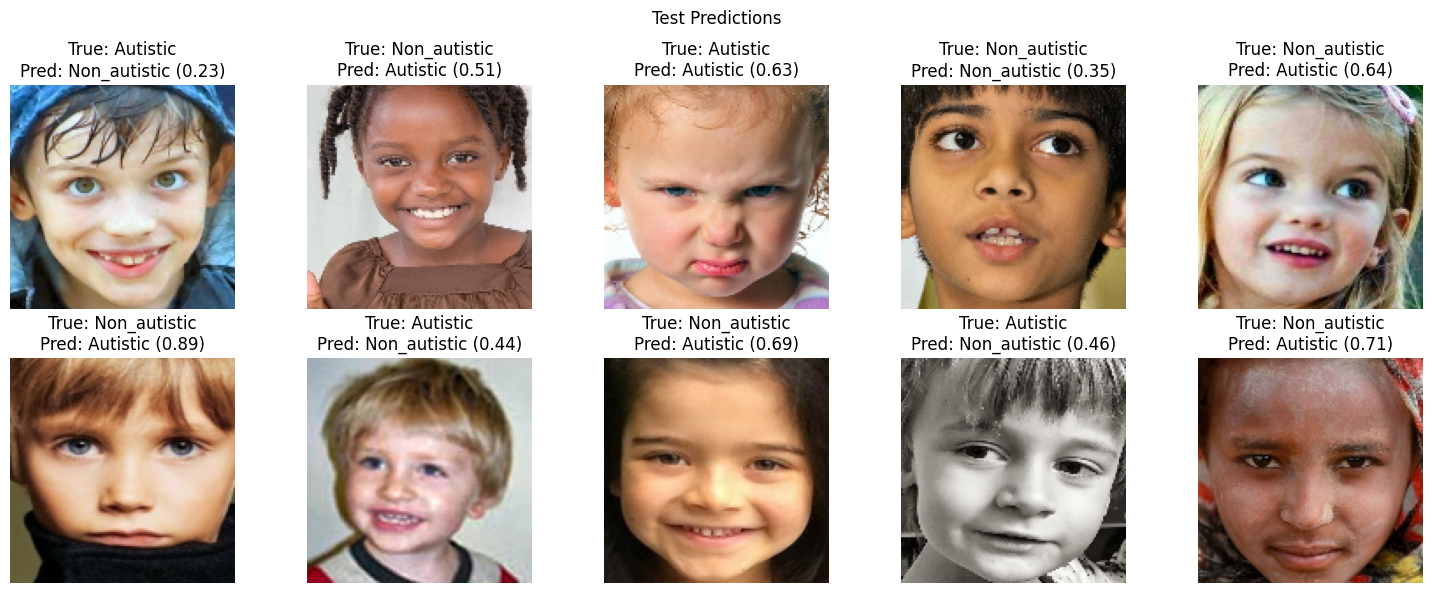

In [58]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax in axes.flat:
    idx = np.random.randint(0, len(X_test))
    pred = model.predict(X_test[idx:idx+1], verbose=0)[0][0]
    ax.imshow(X_test[idx])
    ax.set_title(f"True: {'Autistic' if y_test[idx] == 0 else 'Non_autistic'}\nPred: {'Autistic' if pred > 0.5 else 'Non_autistic'} ({pred:.2f})")
    ax.axis('off')
plt.suptitle('Test Predictions')
plt.tight_layout()
plt.show()

In [ ]:
model.save('model/autism_cnn_model.h5')